In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [8]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

### Visualize

Text(0, 0.5, 'Normalized Euclidean Distance')

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


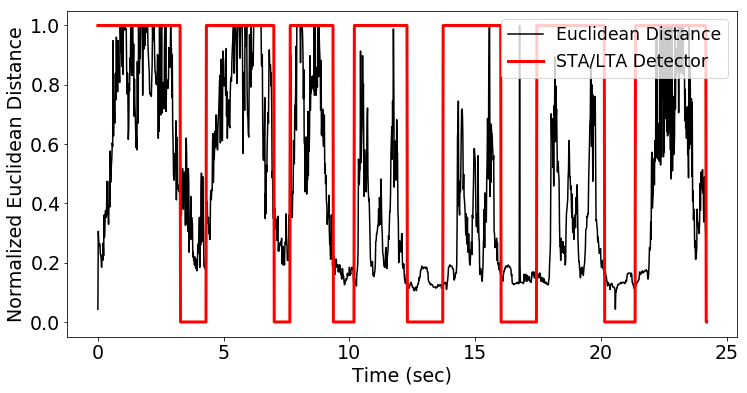

In [10]:
idx = 2
plt.plot(timevec,margin_ts[idx]/max(margin_ts[idx]),color='black')
plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# plt.savefig(str(idx)+' gesture detect.png',dpi=400)

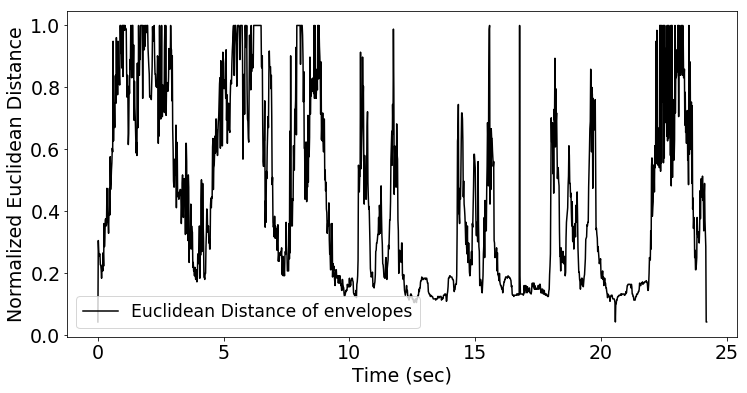

In [12]:
idx = 2
plt.plot(timevec,margin_ts[idx]/max(margin_ts[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance of envelopes'], loc = 'best', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
plt.savefig(str(idx)+' gesture.png',dpi=500)

In [18]:
np.unique(np.argmax(y_test3[idx],-1))

array([ 0,  1,  2,  3, 10, 11, 12])

In [10]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [11]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [12]:
numgest = [gesture_counter(m) for m in mask_spect_ts]
sum(numgest)

813

In [13]:
num_class = y_test3.shape[2]
num_class

19

In [14]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [15]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts) 
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

/home/m/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)


In [16]:
y_int_train = np.array([np.argmax(y,-1) for y in y3train])
y_int_test = np.array([np.argmax(y,-1) for y in y3test])
print(y_int_train.shape)

(3042,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Multi-task labels

In [17]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

### CTC labels

In [18]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [19]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]

In [20]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [21]:
def data_generator_ctc(data, labels, labels2, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            label2 = labels2[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            y_train2 = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(label2[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)

            # yield the next training batch            
            yield [X_train, y_train], [y_train, y_train2]

In [22]:
def data_generator_ctc_nolabel(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

In [23]:
train_dataset = data_generator_ctc(x3train, ctc_tr3, y_mov_tr)
validation_dataset = data_generator_ctc(x3test, ctc_ts3, y_mov_ts)
predict_generator = data_generator_ctc_nolabel(x3test, ctc_ts3)

In [23]:
input_shape = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
input_shape

(None, 128, 128, 3)

# Model

In [23]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [26]:
def ctc_loss_fn(y_true,y_pred, input_length, label_length):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    return(tf.nn.ctc_loss(y_pred, y_true, input_length, label_length,
         preprocess_collapse_repeated=False, ctc_merge_repeated=False, 
         time_major=True))

In [27]:
def ctc_md3():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
        new_shape = (-1, (128//2**3) *64)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
#         cnv2 = TimeDistributed(Flatten(), name="flat")(cnv1)
        out_aux1 = TimeDistributed(Dense(4, activation='softmax'), name="aux_loss")(cnv1)
        
        losses = {
            "ctc_loss": None,
            "aux_loss": "categorical_crossentropy"
        }
#         metrics=['mse','accuracy']
        lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc, out_aux1], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss_weights = [1, 1])
        
        return model

In [129]:
model = ctc_md3()
# model.summary(line_length=120)

In [24]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

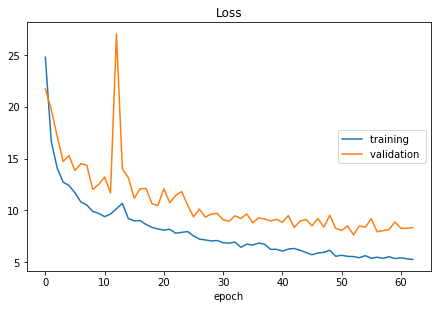

Loss
	training         	 (min:    4.421, max:   24.779, cur:    5.251)
	validation       	 (min:    7.226, max:   27.037, cur:    8.329)
3042/3042 [==============================] - 56s 18ms/step - loss: 5.2506 - val_loss: 8.3293


In [131]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [132]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [133]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [134]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCC


In [135]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [136]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [137]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

89.45945945945945

# MD all aux

In [25]:
def data_generator_multi_md(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]

In [57]:
def data_generator_multi_nolabel_md(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

In [58]:
train_dataset = data_generator_multi_md([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_md([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_md([x1test, x2test, x3test])

In [61]:
def ctc_md3_aux(): # 90.27%
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
        new_shape = (-1, (128//2**3) *64)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
#         cnv2 = TimeDistributed(Flatten(), name="flat")(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc, out_asldaily, out_twohanded,
                                                                     out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss_weights = [1, 0.2, 0.2,0.2,0.2,0.2,])
        
        return model

In [62]:
model_md_aux = ctc_md3_aux()

In [25]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

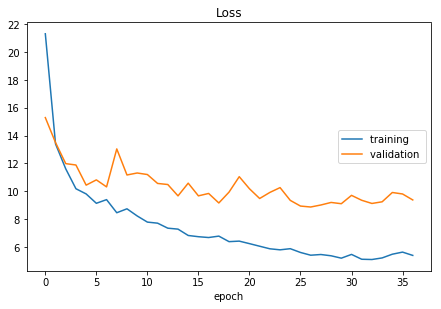

Loss
	training         	 (min:    4.438, max:   23.910, cur:    5.396)
	validation       	 (min:    7.338, max:   20.842, cur:    9.380)
3042/3042 [==============================] - 61s 20ms/step - loss: 5.3963 - val_loss: 9.3799


In [64]:
history = model_md_aux.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [65]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model_md_aux.get_layer(name="image").input, model_md_aux.get_layer(name="dense2").output
)
# prediction_model.summary()

In [66]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [67]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

GGCCCCCCCCCCCCA


In [68]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [69]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

86.35135135135134

In [51]:
# save model
fname = 'ctc aux multitask md 90-27'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model_md_aux.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model_md_aux.save_weights(WEIGHT_FILE)

## RD multitask

In [93]:
def data_generator_multi_rd(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train2, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]

In [94]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train2]

In [95]:
train_dataset = data_generator_multi_rd([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_rd([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_rd([x1test, x2test, x3test])

In [96]:
input_shape_vid = (None, x1train[0].shape[1], x1train[0].shape[2], x1train[0].shape[3], x1train[0].shape[4])
input_shape_vid

(None, 5, 128, 128, 3)

In [122]:
def ctc_rd():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="ra")
#         inputlayer2 = Input(shape = input_shape_vid, name="ra")
#         inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        
#         y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
#         y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
#         new_shape2 = (-1, (128//2**3) *64 *5)
#         cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
#         cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
#         cnv2 = Dropout(0.5)(cnv2)
#         cnv2 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv2)
        
#         z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
#         z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
#         z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
#         z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
#         z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
#         z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
#         z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
#         new_shape3 = (-1, (128//2**3) *64)
#         cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
#         cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
#         cnv3 = Dropout(0.5)(cnv3)
#         cnv3 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv3)
    
#         concat = concatenate([cnv1,cnv2,cnv3])
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [123]:
model_rd_aux = ctc_rd()

In [124]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

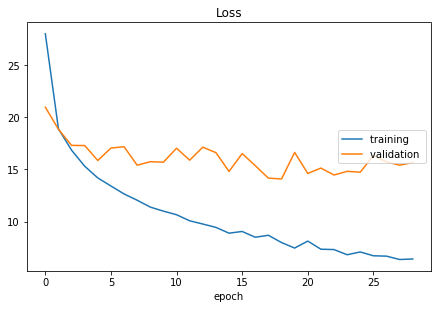

Loss
	training         	 (min:  -57.880, max:   52.837, cur:    6.415)
	validation       	 (min:  -48.188, max:   47.771, cur:   15.659)
3042/3042 [==============================] - 163s 54ms/step - loss: 6.4146 - val_loss: 15.6590


In [125]:
history = model_rd_aux.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [126]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model_rd_aux.get_layer(name="ra").input, model_rd_aux.get_layer(name="dense2").output
)
# prediction_model.summary()

In [127]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [128]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCA


In [129]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [130]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

72.83783783783784

In [131]:
# save model
fname = 'ctc aux multitask ra 72-8'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model_rd_aux.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model_rd_aux.save_weights(WEIGHT_FILE)

# Fusion

In [25]:
def data_generator_multi_rd(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]

In [36]:
def data_generator_multi_rd2(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train, y_train2, y_train3, y_train4, y_train5, y_train6], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]

In [27]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [131]:
train_dataset = data_generator_multi_rd2([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_rd2([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_rd([x1test, x2test, x3test])

In [29]:
model_file = 'Models/ctc aux multitask ra 72-8.json'
w_file = 'Models/ctc aux multitask ra 72-8.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_ra.load_weights(w_file)

In [30]:
model_file = 'Models/ctc aux multitask rd 80-0.json'
w_file = 'Models/ctc aux multitask rd 80-0.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_rd.load_weights(w_file)

In [31]:
model_file = 'Models/ctc aux multitask md 90-27.json'
w_file = 'Models/ctc aux multitask md 90-27.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [32]:
# rename layers
model_ra.get_layer('reshape')._name = model_ra.get_layer('reshape').name + '_2'
model_md.get_layer('reshape')._name = model_md.get_layer('reshape').name + '_3'
model_ra.get_layer('dense1')._name = model_ra.get_layer('dense1').name + '_2'
model_md.get_layer('dense1')._name = model_md.get_layer('dense1').name + '_3'

In [114]:
labels = Input(name="label", shape=(None,))#, dtype="float32")
asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")

merged_layers = concatenate([model_rd.layers[-9].output,model_ra.layers[-9].output,model_md.layers[-9].output])
aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(merged_layers)
out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)

out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  
# model_multi = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
#                             outputs = out_ctc, 
#                            name="ctc_model")
model_multi = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels, asl, hand, loc, mov, stroke], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
model_multi.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
# model_multi.compile(optimizer=opt)

In [115]:
# Freeze the layers except the last 7 layers
# for layer in model_multi.layers[:-2]:
#     layer.trainable = False

# Check the trainable status of the individual layers
# for layer in model_multi.layers:
#     print(layer, layer.trainable)

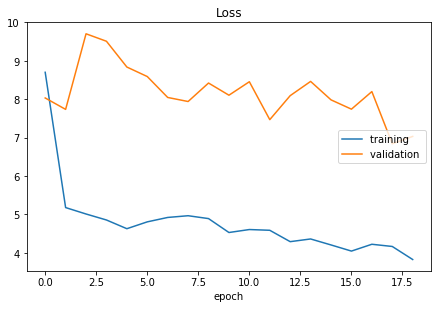

Loss
	training         	 (min:    3.627, max:    8.702, cur:    3.826)
	validation       	 (min:    6.841, max:   10.269, cur:    7.032)
3042/3042 [==============================] - 341s 112ms/step - loss: 3.8257 - val_loss: 7.0318
Epoch 20/100
 950/3042 [========>.....................] - ETA: 3:33 - loss: 4.3087

KeyboardInterrupt: 

In [116]:
history = model_multi.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

## import saved

In [124]:
# # save model
# fname = 'ctc aux multiinput multitask 89-4 final'
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model_multi.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model_multi.save_weights(WEIGHT_FILE)

In [36]:
# json_file = open(MODEL_FILE, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
# model_load.load_weights(WEIGHT_FILE)

In [117]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_multi.get_layer(name="rd").input, model_multi.get_layer(name="ra").input, model_multi.get_layer(name="image").input], model_multi.get_layer(name="dense2").output
)
# prediction_model.summary()

In [118]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [119]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCCCCCAA


In [120]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAABBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCCCCCCCCCCCCCAA | ACCCCCCCCAA :Original
4. Predicted: NNNNNNNNNNNNNA | NNNNNNNNNN :Original
5. Predicted: AAAAAAAAAAOOOOOOOOOOOOOOOOOOAA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: AAAAAAPPPPPPPPPPPPPPPPPPPP | AAPPPPPPPPPPPPPA :Original
7. Predicted: AADDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAAAAANNNNNNNAA | AAANNNNNNNNAA :Original
10. Predicted: AAAAAMMMMMMMOOOOOOOOAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: AAAAAPPPPPPPPPPPPPPPPPPPPPPA | APPPPPPPPPPPPPPPA :Original
12. Predicted: ADDDDDDDDAA | ADDDDDDDDAA :Original
13. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBB :Original
14. Predicted: BBBBBBBBBBBBBBB | BBBBBBBBBBBBBBA :Original
15. Predicted: CCCCCCCCCCCCCCAA | ACCCCCCCCAA :Original
16. Predicted: AAKKKKKKKKKHAA | AKKKKKKKKKAA :Original
17. Predict

In [121]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [122]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

89.45945945945945

In [123]:
# ##### import pandas as pd
# import seaborn as sn
# font = {'family' : 'normal', 
#         'weight' : 'bold',
#         'size'   : 6}

# plt.rc('font', **font) 
# plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=12) 
# Y_pred = np.array([ord(y)%32-1 for y in mode_pred]) 
# Y_test_int = np.array([ord(y)%32-1 for y in mode_orig]) 
# data = {'y_Predicted': Y_pred,
#         'y_Actual':    Y_test_int
#         }

# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
# confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], normalize='index', rownames=['Actual'], 
#                                colnames=['Predicted'], margins = False)\
# .round(3)*100
# fig = plt.figure(dpi=180)
# sn.heatmap(confusion_matrix,annot=True, cmap="Greens", fmt='g') # cbar_kws={'format': '%.0f%%'},
# b, t = plt.ylim()
# b += 0.5
# t -= 0.5
# plt.ylim(b,t)
# cap = plt.gcf()
# plt.savefig('results/multitask multi input ctc.png', dpi = 400)
# plt.show

## Task's performance with MTL

In [36]:
# # save model
# fname = 'ctc aux multiinput multitask '
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model_multi.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model_multi.save_weights(WEIGHT_FILE)

In [37]:
# json_file = open(MODEL_FILE, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
# model_load.load_weights(WEIGHT_FILE)

In [99]:
# for i in model_multi.layers:
#     print(i.name)

In [128]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_multi.get_layer(name="rd").input, model_multi.get_layer(name="ra").input, model_multi.get_layer(name="image").input], model_multi.get_layer(name="asldaily").output
)
# prediction_model.summary()

In [132]:
pred = np.array([np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [133]:
pred_labels = np.array([p for p in pred])
print(pred[0].shape)
task_gt = np.array([np.squeeze(np.argmax(y,-1)) for y in y_asldaily_ts])
print(task_gt[0].shape)

(20,)
(20,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [135]:
pred.shape

(740,)

In [136]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in task_gt]
mode_pred = [max(Counter(y)) for y in pred]

In [137]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(mode_orig))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

56.08108108108109

## Aux Task only

In [138]:
def data_generator_multi_rd_task(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield X_train3, y_train2

In [139]:
def data_generator_multi_nolabel_rd_task(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield X_train3

In [140]:
train_dataset = data_generator_multi_rd_task([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_rd_task([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel_rd_task([x1test, x2test, x3test])

In [144]:
for i in model_rd.layers:
    print(i.name)

rd
time_distributed_56
time_distributed_57
time_distributed_58
time_distributed_59
time_distributed_60
time_distributed_61
time_distributed_62
reshape
dense1
dropout_8
bidirectional_8
label
dense2
ctc_loss
asldaily
twohanded
major
movement
stroke


In [150]:
labels = Input(name="label", shape=(None,))#, dtype="float32")
asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")

merged_layers = concatenate([model_rd.layers[-9].output,model_ra.layers[-9].output,model_md.layers[-9].output])
lstm_layer = model_md.layers[-9].output
aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(lstm_layer)
out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)

out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  
# model_multi = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
#                             outputs = out_ctc, 
#                            name="ctc_model")
model_task = keras.Model(inputs = [model_md.get_layer('image').input], 
                            outputs = [out_asldaily], 
                           name="ctc_model")
model_task.compile(optimizer=opt, loss = 'categorical_crossentropy')
# model_multi.compile(optimizer=opt)

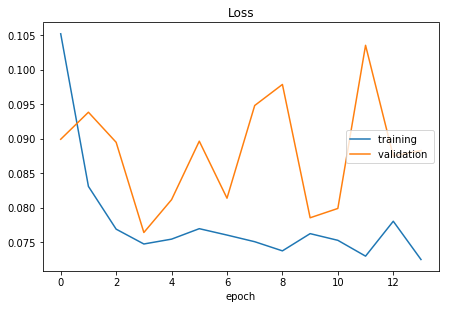

Loss
	training         	 (min:    0.072, max:    8.702, cur:    0.072)
	validation       	 (min:    0.076, max:   10.269, cur:    0.088)
3042/3042 [==============================] - 53s 17ms/step - loss: 0.0725 - val_loss: 0.0883


In [151]:
history = model_task.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [80]:
# # save model
# fname = 'ctc aux multiinput multitask 90-8'
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model_multi.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model_multi.save_weights(WEIGHT_FILE)

In [36]:
# json_file = open(MODEL_FILE, 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
# model_load.load_weights(WEIGHT_FILE)

In [152]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_task.get_layer(name="image").input], model_task.get_layer(name="asldaily").output
)
# prediction_model.summary()

In [153]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [154]:
pred_labels = np.array([p for p in pred])
print(pred[0].shape)
task_gt = np.array([np.squeeze(np.argmax(y,-1)) for y in y_asldaily_ts])
print(task_gt[0].shape)

(20,)
(20,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
# for idx in range(len(ctc_ts3)):
#     print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

In [157]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in task_gt]
mode_pred = [max(Counter(y)) for y in pred]

In [158]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(mode_orig))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

99.1891891891892

## Uncert

In [59]:
def data_generator_multi_uncert(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train3, y_train, y_train2, y_train3, y_train4, y_train5, y_train6], np.concatenate([y_train2, y_train3, y_train4, y_train5, y_train6],-1)
            
#             [y_train2, y_train3, y_train4, y_train5, y_train6]

In [60]:
def data_generator_multi_uncert_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

In [61]:
train_dataset = data_generator_multi_uncert([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_uncert([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_uncert_nolabel([x1test, x2test, x3test])

In [67]:
def ctc_md3_un(): 
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
        hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
        loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
        mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
        stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
        new_shape = (-1, (128//2**3) *64)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
#         cnv2 = TimeDistributed(Flatten(), name="flat")(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        out = CustomMultiLossLayer_ctc(nb_outputs = 6)([labels, asl, hand, loc, mov, stroke,
#                                                      asl, hand, loc, mov, stroke])
                                                   x2, out_asldaily, out_twohanded,
                                                   out_major, out_movement, out_stroke])
        
        model = keras.Model(inputs = [inputlayer, 
                            labels, asl, hand, loc, mov, stroke], 
                            outputs = out, 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss=None)
        
        return model

In [68]:
model_md_un = ctc_md3_un()

In [69]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

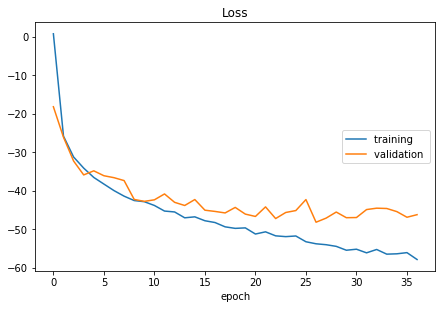

Loss
	training         	 (min:  -57.880, max:   52.837, cur:  -57.880)
	validation       	 (min:  -48.188, max:   47.771, cur:  -46.228)
3042/3042 [==============================] - 69s 23ms/step - loss: -57.8803 - val_loss: -46.2275


In [70]:
history = model_md_un.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [71]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model_md_un.get_layer(name="image").input, model_md_un.get_layer(name="dense2").output
)
# prediction_model.summary()

In [72]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [73]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCC


In [74]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [75]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

87.70270270270271

### Attention

In [31]:
import keras.backend as K
class Attention(Layer):
    
    def __init__(self,  return_sequences=True):
        self.return_sequences = return_sequences
#         self.length = length
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=None,
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [32]:
def ctc_md3_x(): 
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
#         x = TimeDistributed(Flatten())(x)
        
        new_shape = (-1, (128//2**3) *64)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        cnv1 = Attention(return_sequences = True)(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
#         cnv2 = TimeDistributed(Flatten(), name="flat")(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = [inputlayer, labels], outputs = [out_ctc, out_asldaily, out_twohanded,
                                                                     out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss_weights = [1, 0.2, 0.2,0.2,0.2,0.2,])
        
        return model

In [35]:
model_md_att = ctc_md3_x()

In [36]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

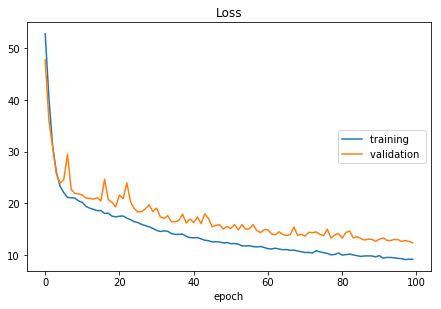

Loss
	training         	 (min:    9.119, max:   52.837, cur:    9.175)
	validation       	 (min:   12.347, max:   47.771, cur:   12.347)
3042/3042 [==============================] - 58s 19ms/step - loss: 9.1754 - val_loss: 12.3468


In [37]:
history = model_md_att.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [38]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model_md_att.get_layer(name="image").input, model_md_att.get_layer(name="dense2").output
)
# prediction_model.summary()

In [39]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [40]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCC


In [41]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [42]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

75.54054054054053

# Multi-input Multi-task

In [43]:
def data_generator_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]

In [44]:
def data_generator_multi_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [45]:
train_dataset = data_generator_multi([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_nolabel([x1test, x2test, x3test])

In [46]:
input_shape_vid = (None, x1train[0].shape[1], x1train[0].shape[2], x1train[0].shape[3], x1train[0].shape[4])
input_shape_vid

(None, 5, 128, 128, 3)

In [47]:
def ctc_md_multi():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5)
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
        new_shape2 = (-1, (128//2**3) *64 *5)
        cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
        cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
        cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv2)
        
        z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
        new_shape3 = (-1, (128//2**3) *64)
        cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
        cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
        cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3])
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(concat)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(concat)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(concat)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(concat)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(concat)
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [48]:
model_multi = ctc_md_multi()
# model.summary(line_length=120)

In [49]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

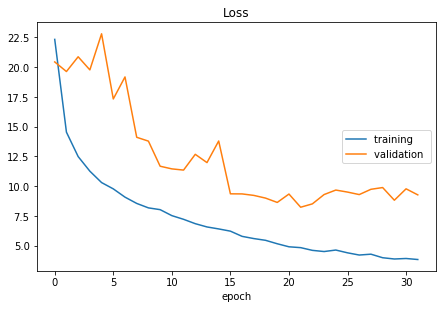

Loss
	training         	 (min:    3.839, max:   52.837, cur:    3.839)
	validation       	 (min:    8.230, max:   47.771, cur:    9.267)
3042/3042 [==============================] - 339s 111ms/step - loss: 3.8392 - val_loss: 9.2670


In [50]:
history = model_multi.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [51]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_multi.get_layer(name="rd").input, model_multi.get_layer(name="ra").input, 
    model_multi.get_layer(name="image").input], model_multi.get_layer(name="dense2").output
)
# prediction_model = keras.models.Model(
#     model_multi.inputs, model_multi.get_layer(name="dense2").output
# )
# prediction_model.summary()

In [52]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [53]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCCCCCCCCCCCCCA


In [54]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCCCCCCCCCCCCCCCCCCCCA | ACCCCCCCCAA :Original
4. Predicted: NNNNNNNNNA | NNNNNNNNNN :Original
5. Predicted: AAAAAAAAAOOOOOOOOOOOOOOOOOOAAA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: AAPPPPPPPPPPPPPPPPPPPA | AAPPPPPPPPPPPPPA :Original
7. Predicted: AAAADDDDDDDDDDDDDDDDDDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAANNINNNNMA | AAANNNNNNNNAA :Original
10. Predicted: AAAALMMOMQQQQSHLLAAAAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: APPPPPPPPPPPPPPPPPPPPPPPP | APPPPPPPPPPPPPPPA :Original
12. Predicted: AADDDDDDDDDDDDDDDDDDD | ADDDDDDDDAA :Original
13. Predicted: AABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBB :Original
14. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBBBA :Original
15. Predict

In [55]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [56]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

85.0

In [202]:
# save model
fname = 'ctc multitask multi input md'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model_multi.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model_multi.save_weights(WEIGHT_FILE)

In [214]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'hist/' + fname + ' history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'hist/' + fname + ' history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Uncertainty Loss

In [627]:
def data_generator_multi_uncert(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train, y_train2, y_train3, y_train4, y_train5, y_train6], np.concatenate([y_train2, y_train3, y_train4, y_train5, y_train6],-1)
            
#             [y_train2, y_train3, y_train4, y_train5, y_train6]

In [671]:
def data_generator_multi_uncert_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [757]:
train_dataset = data_generator_multi_uncert([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_multi_uncert([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_uncert_nolabel([x1test, x2test, x3test])

In [740]:
x = next(train_dataset)

In [741]:
x[0][0].shape

(1, 20, 5, 128, 128, 3)

In [742]:
from keras.initializers import Constant
class CustomMultiLossLayer_original(Layer): #https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer_original, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer_original, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

In [743]:
class CTCLayer_uncert(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [62]:
from keras import backend as K
class CustomMultiLossLayer_ctc(Layer):
    def __init__(self, nb_outputs=6, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer_ctc, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=keras.initializers.Constant(0.), trainable=True)]
        super(CustomMultiLossLayer_ctc, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
#         print('ystrue: '+str(len(ys_true)))
#         print('nb_outputs: '+str(self.nb_outputs))
#         print('yspred: '+str(len(ys_pred)))
        
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        ctc_loss_fn = keras.backend.ctc_batch_cost
        cnt = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
#             print(K.int_shape(y_true))
#             print(K.int_shape(y_pred))
#             assert y_true.shape == y_pred.shape, 'shapes not match'
            if cnt > 0: # if auxilary
                precision = K.exp(-log_var[0])
                loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
#                 print('aux: ' + str(cnt))
            if cnt == 0: # if ctc labels
#                 y_true = tf.expand_dims(y_true,0)
#                 y_pred = tf.expand_dims(y_pred,0)
                batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#                 print('ctc: ' + str(cnt))
                input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
                label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
                input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
                label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
                loss += ctc_loss_fn(y_true, y_pred, input_length, label_length)
            cnt += 1
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
#         for i in range(len(inputs)):
#             print(inputs[i].get_shape())
#         del inputs[6]
#         del inputs[0]
        trues = K.concatenate(inputs[1:6], -1)
        preds = K.concatenate(inputs[7:], -1)
        cat_out = K.concatenate([trues,preds], -1)
#         print(cat_out.shape)
        return cat_out
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'nb_outputs': self.nb_outputs,
            'is_placeholder': self.is_placeholder,
            'log_vars': self.log_vars,
            'add_weight': self.add_weight,
            'add_loss': self.add_loss,
        })
        return config

In [795]:
from keras import backend as K
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=6, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=keras.initializers.Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        cat_out = K.concatenate(ys_pred, -1)
        return cat_out
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'nb_outputs': self.nb_outputs,
            'is_placeholder': self.is_placeholder,
            'log_vars': self.log_vars,
            'add_weight': self.add_weight,
            'add_loss': self.add_loss,
        })
        return config

In [796]:
# debug
x = next(train_dataset)
y = x[0][3:]
len(y)
out = CustomMultiLossLayer(nb_outputs = 5)([y[1], y[2], y[3], y[4], y[5],
                                            y[1], y[2], y[3], y[4], y[5]])
#                                                    out_asldaily, out_twohanded,
#                                                    out_major, out_movement, out_stroke])

In [797]:
len(y)

6

In [798]:
def ctc_md_multi_uncertainty():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
        hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
        loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
        mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
        stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5 )
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
        new_shape2 = (-1, (128//2**3) *64 *5 )
        cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
        cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
        cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv2)
        
        z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
        new_shape3 = (-1, (128//2**3) *64 )
        cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
        cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
        cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3], name = 'concatlayer')
#         concat = K.print_tensor(concat, message = 'concatprint') # [tf.shape(out_asldaily)]
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(concat)
                                
        out_asldaily = TimeDistributed(Dense(2, activation='sigmoid'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
#         out_asldaily = K.print_tensor(out_asldaily, message = 'asloutx') # [tf.shape(out_asldaily)]
#         out_twohanded = K.print_tensor(out_twohanded, message = 'out_twohanded') # [tf.shape(out_asldaily)]
#         out_major = K.print_tensor(out_major, message = 'out_major') # [tf.shape(out_asldaily)]
#         out_movement = K.print_tensor(out_movement, message = 'out_movement') # [tf.shape(out_asldaily)]
#         out_stroke = K.print_tensor(out_stroke, message = 'out_stroke') # [tf.shape(out_asldaily)]
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out = CustomMultiLossLayer_ctc(nb_outputs = 6)([labels, asl, hand, loc, mov, stroke,
#                                                      asl, hand, loc, mov, stroke])
                                                   x2, out_asldaily, out_twohanded,
                                                   out_major, out_movement, out_stroke])
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, 
                            labels, asl, hand, loc, mov, stroke], 
                            outputs = out, 
                           name="ctc_model")
#         model = keras.Model([inputlayer, inputlayer2, inputlayer3, labels,
#                             ], out)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, run_eagerly=False, loss = None)
        
        return model

In [799]:
model_multi_uncert = ctc_md_multi_uncertainty()
# model_multi_uncert = get_trainable_model(pred_model_multi)
# model_multi_uncert.summary(line_length=120)

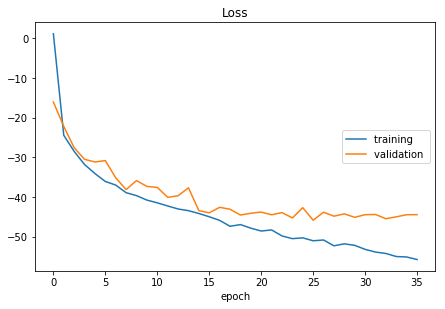

Loss
	training         	 (min: -301.572, max:      inf, cur:  -55.762)
	validation       	 (min: -547.374, max:      inf, cur:  -44.455)
3042/3042 [==============================] - 353s 116ms/step - loss: -55.7617 - val_loss: -44.4547


In [768]:
history = model_multi_uncert.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [779]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model_multi_uncert.get_layer(name="rd").input, model_multi_uncert.get_layer(name="ra").input, 
    model_multi_uncert.get_layer(name="image").input], model_multi_uncert.get_layer(name="dense2").output
)
# prediction_model = keras.models.Model(
#     model_multi.inputs, model_multi.get_layer(name="dense2").output
# )
# prediction_model.summary()

In [770]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [771]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCCCCCCCCA


In [772]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: AAAABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCCCCCCCCA | ACCCCCCCCAA :Original
4. Predicted: ANNNNNNNNNNNAA | NNNNNNNNNN :Original
5. Predicted: AAAAAAAOOOOOOOOOOOOOOOAAAAA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: AAAPPPPPPPPPPPPPPAA | AAPPPPPPPPPPPPPA :Original
7. Predicted: AAAAADDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAANNNNNNNAAA | AAANNNNNNNNAA :Original
10. Predicted: AAAALLLLLLOAAAAAAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: AAAOPPPPPPPPPPPPPPA | APPPPPPPPPPPPPPPA :Original
12. Predicted: ADDDDDDDDDD | ADDDDDDDDAA :Original
13. Predicted: AABBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBBBBBB :Original
14. Predicted: BBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBBBA :Original
15. Predicted: CCCCCCCCCCCCA | ACCCCCCCCAA :Original
16. Predicted: AAKKKKKKKKKKAA | AKKKKKKKKKAA :Original
17.

In [773]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [774]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

86.75675675675676

In [780]:
# save model
fname = 'ctc aux multitask multi input uncert'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model_multi_uncert.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
# prediction_model.save_weights(WEIGHT_FILE)

In [781]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'hist/' + fname + ' history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'hist/' + fname + ' history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Add CTC

In [719]:
def data_generator_ctc(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
#             asldaily = labels[1][offset:offset+batch_size]
#             twohand = labels[2][offset:offset+batch_size]
#             major = labels[3][offset:offset+batch_size]
#             move = labels[4][offset:offset+batch_size]
#             stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
#             y_train2 = []
#             y_train3 = []
#             y_train4 = []
#             y_train5 = []
#             y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train2.append(asldaily[i])
#                 y_train3.append(twohand[i])
#                 y_train4.append(major[i])
#                 y_train5.append(move[i])
#                 y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
#             y_train2 = np.array(y_train2)
#             y_train3 = np.array(y_train3)
#             y_train4 = np.array(y_train4)
#             y_train5 = np.array(y_train5)
#             y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], y_train
#             [np.concatenate([y_train2, y_train3, y_train4, y_train5, y_train6],-1)]
#             [y_train2, y_train3, y_train4, y_train5, y_train6]

In [720]:
train_dataset = data_generator_ctc([x1train, x2train, x3train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_ctc([x1test, x2test, x3test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_multi_uncert_nolabel([x1test, x2test, x3test])

In [721]:
# aux_model = keras.models.Model([model_multi_uncert.get_layer(name="rd").input, model_multi_uncert.get_layer(name="ra").input, 
# model_multi_uncert.get_layer(name="image").input, model_multi_uncert.get_layer(name="label").input], model_multi_uncert.get_layer(name="concatlayer").output
# )

x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(model_multi_uncert.get_layer(name="concatlayer").output)
out_ctc = CTCLayer(name="ctc_loss")(model_multi_uncert.get_layer(name="label").output, x2)

ctc_modelx = keras.Model(inputs = [model_multi_uncert.get_layer(name="rd").input, model_multi_uncert.get_layer(name="ra").input, 
model_multi_uncert.get_layer(name="image").input, model_multi_uncert.get_layer(name="label").input], outputs = out_ctc)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
ctc_modelx.compile(optimizer=opt)
ctc_modelx.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rd (InputLayer)                 [(None, None, 5, 128 0                                            
__________________________________________________________________________________________________
ra (InputLayer)                 [(None, None, 5, 128 0                                            
__________________________________________________________________________________________________
image (InputLayer)              [(None, None, 128, 1 0                                            
__________________________________________________________________________________________________
time_distributed_2440 (TimeDist (None, None, 5, 128, 2624        rd[0][0]                         
______________________________________________________________________________________

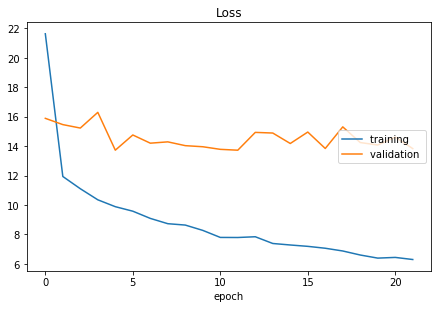

Loss
	training         	 (min: -301.572, max:      inf, cur:    6.295)
	validation       	 (min: -547.374, max:      inf, cur:   13.836)
3042/3042 [==============================] - 484s 159ms/step - loss: 6.2954 - val_loss: 13.8359


In [722]:
history2 = ctc_modelx.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [723]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [ctc_modelx.get_layer(name="rd").input, ctc_modelx.get_layer(name="ra").input, 
    ctc_modelx.get_layer(name="image").input], ctc_modelx.get_layer(name="dense2").output
)
# prediction_model = keras.models.Model(
#     model_multi.inputs, model_multi.get_layer(name="dense2").output
# )
# prediction_model.summary()

In [724]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x3test))]

In [725]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

CCCCC


In [726]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | AAABBBBBBBBBBBBBBBBB :Original
2. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBB :Original
3. Predicted: CCCCC | ACCCCCCCCAA :Original
4. Predicted: NNNNNNNNNNNNNNNNNNNNNN | NNNNNNNNNN :Original
5. Predicted: AAAAOOOOOOOOOOOOOOOOA | AAAAAOOOOOOOOOOOOOAA :Original
6. Predicted: APPPPPPPPPPPPPPPA | AAPPPPPPPPPPPPPA :Original
7. Predicted: ADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD | AAADDDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBCCCCCCC :Original
9. Predicted: AAA | AAANNNNNNNNAA :Original
10. Predicted: AAAA | AAAOOOOOOOOOOOOOAA :Original
11. Predicted: APPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP | APPPPPPPPPPPPPPPA :Original
12. Predicted: DDDDDDDDDDDDDDDDDDDDDDDDDDDDD | ADDDDDDDDAA :Original
13. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB

In [727]:
from collections import Counter
mode_orig = [max(Counter(y)) for y in ctc_ts3]
mode_pred = [max(Counter(y)) if len(y) != 0 else 'A' for y in pred_labels]

In [728]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

71.89189189189189

# Attention

In [805]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],input_shape[1]),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],-1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [806]:
def ctc__multi_att():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        inputlayer2 = Input(shape = input_shape_vid, name="ra")
        inputlayer3 = Input(shape = input_shape, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
        hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
        loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
        mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
        stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        new_shape = (-1, (128//2**3) *64 *5 )
        cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
        
        y = TimeDistributed(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))(inputlayer2)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(y)
        new_shape2 = (-1, (128//2**3) *64 *5 )
        cnv2 = Reshape(target_shape=new_shape2, name="reshape2")(y)
        cnv2 = Dense(64, activation="relu", name="dense3")(cnv2)
        cnv2 = Dropout(0.5)(cnv2)
        cnv2 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv2)
        
        z = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(z)
        z = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(z)
        new_shape3 = (-1, (128//2**3) *64 )
        cnv3 = Reshape(target_shape=new_shape3, name="reshape3")(z)
        cnv3 = Dense(64, activation="relu", name="dense4")(cnv3)
        cnv3 = Dropout(0.5)(cnv3)
        cnv3 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv3)
    
        concat = concatenate([cnv1,cnv2,cnv3], name = 'concatlayer')
#         concat = K.print_tensor(concat, message = 'concatprint') # [tf.shape(out_asldaily)]
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(concat)
        
        att_asldaily = Attention(return_sequences=True)(aux_pool)
        
        out_asldaily = TimeDistributed(Dense(2, activation='sigmoid'), name="asldaily")(att_asldaily)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
#         out_asldaily = K.print_tensor(out_asldaily, message = 'asloutx') # [tf.shape(out_asldaily)]
#         out_twohanded = K.print_tensor(out_twohanded, message = 'out_twohanded') # [tf.shape(out_asldaily)]
#         out_major = K.print_tensor(out_major, message = 'out_major') # [tf.shape(out_asldaily)]
#         out_movement = K.print_tensor(out_movement, message = 'out_movement') # [tf.shape(out_asldaily)]
#         out_stroke = K.print_tensor(out_stroke, message = 'out_stroke') # [tf.shape(out_asldaily)]
        
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(concat)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out = CustomMultiLossLayer_ctc(nb_outputs = 6)([labels, asl, hand, loc, mov, stroke,
#                                                      asl, hand, loc, mov, stroke])
                                                   x2, out_asldaily, out_twohanded,
                                                   out_major, out_movement, out_stroke])
        
        model = keras.Model(inputs = [inputlayer, inputlayer2, inputlayer3, 
                            labels, asl, hand, loc, mov, stroke], 
                            outputs = out, 
                           name="ctc_model")
#         model = keras.Model([inputlayer, inputlayer2, inputlayer3, labels,
#                             ], out)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, run_eagerly=True, loss = None)
        
        return model

In [807]:
model_att = ctc__multi_att()

ValueError: Dimension -1 must be >= 0